# MT-related figures
This notebook reproduces result figures in the paper that came from the fixed diameter cases, with MT effects only (Figure 7)

In [1]:
# First import the relevant packages and functions
from local_optim_fit import reorder_df, forge_axcaliber, fit_dict_axcaliber, fit_params
from dmipy.signal_models import gaussian_models, cylinder_models
from dmipy.core.acquisition_scheme import acquisition_scheme_from_qvalues,  acquisition_scheme_from_gradient_strengths
from dmipy.distributions import distribute_models

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit, minimize
import pandas as pd
from scipy.stats import gamma
from scipy.interpolate import CubicSpline, interp1d
from matplotlib.ticker import LinearLocator
import copy
import pickle

/Users/zxh380/opt/anaconda3/envs/dmipy/lib/python3.12/site-packages/dmipy-1.0.5-py3.12.egg/dmipy/utils/utils.py:6: UserWarning: Pass ['name'] as keyword args. From version 2.0.0 passing these as positional arguments will result in an error. 
/Users/zxh380/opt/anaconda3/envs/dmipy/lib/python3.12/site-packages/dmipy-1.0.5-py3.12.egg/dmipy/optimizers_fod/csd_cvxpy.py:8: UserWarning: Pass ['name'] as keyword args. From version 2.0.0 passing these as positional arguments will result in an error. 
/Users/zxh380/opt/anaconda3/envs/dmipy/lib/python3.12/site-packages/dmipy-1.0.5-py3.12.egg/dmipy/optimizers_fod/csd_tournier.py:6: UserWarning: Pass ['name'] as keyword args. From version 2.0.0 passing these as positional arguments will result in an error. 
/Users/zxh380/opt/anaconda3/envs/dmipy/lib/python3.12/site-packages/dmipy-1.0.5-py3.12.egg/dmipy/optimizers_fod/csd_plus.py:10: UserWarning: Pass ['name'] as keyword args. From version 2.0.0 passing these as positional arguments will result in a

### Fit the raw data
We use two custom functions based on dmipy package and scipy to create our forward model -- the two-compartment model (`forge_axcaliber`), and fit the model to simulated data (`fit_params`).

In [3]:
# Create lists to store fitted parameters and fitting costs (squared errors)
costs = []
params = []

# Call the custom function to construct the forward model from interpolating simulated dictionary of intraaxonal signals at different radius values.
forward_model = forge_axcaliber()

# Loop through the relevant MT and radius values and fit the forward model to the total signal 
for MT in range(20, 151, 10): # Note MT strength defined as the effective T2 it introduces
    mt_costs = []
    mt_params = []
    for r in np.arange(0.3, 5.51, 0.1):
        
        # read the relevant signal file
        simdata = pd.read_csv("./MT_results/signal_MT_"+ str(MT) + "_sus_0_perm_0.000_rmean_" + '{0:.2f}'.format(r) + "_density_0.65.csv", header=None)
        y = simdata[2].to_numpy()/simdata[2][0] # and calculate the DW attenuation
        
        # Fit the model using the custom function which performs a least square fitting
        cost, param = fit_params(forward_model, y)
        
        # Store the fitting costs and fitted parameters in the correct lists
        mt_costs.append(cost)
        mt_params.append(param)
    costs.append(mt_costs)
    params.append(mt_params)

/Users/zxh380/opt/anaconda3/envs/dmipy/lib/python3.12/site-packages/scipy-1.15.1-py3.12-macosx-10.13-x86_64.egg/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/Users/zxh380/opt/anaconda3/envs/dmipy/lib/python3.12/site-packages/scipy-1.15.1-py3.12-macosx-10.13-x86_64.egg/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/Users/zxh380/opt/anaconda3/envs/dmipy/lib/python3.12/site-packages/scipy-1.15.1-py3.12-macosx-10.13-x86_64.egg/scipy/optimize/_diff

In [4]:
with open("precomputed_mt_params.pickle", 'wb') as file:
    pickle.dump(params, file)

To skip fitting parameters from raw data, use the pre-fitted parameters

In [ ]:
file_path = "precomputed_mt_params.pickle"
with open(file_path, 'rb') as file:
    params = pickle.load( file)

A custom function to read the fitted parameters from the dictionary storing them

In [21]:
def read_fits(param_dict):

    nm_fit = []
    for a in param_dict:
        nm_fit.append(a["Nelder-Mead"])

    nm_fit = np.array(nm_fit)
    return nm_fit

### Figure 7a
Plot the fitted diameters across the range of underlying diameters at different MT effective T2 values

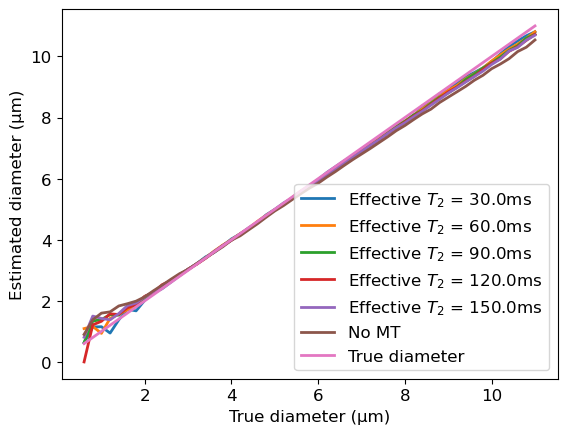

In [22]:
# List the MT values of interest
mts = range(30,151,30)

# read the fitted diameter across the whole range of underlying cylinder diameter when there's no MT or permeability (first element of the permeability results)
file_path = "precomputed_perm_params.pickle"
with open(file_path, 'rb') as file:
    params_perm = pickle.load(file)
nm_fit0 = read_fits(params_perm[0])

# For each MT effective T2 values extract the fitted diameters across the whole range of underlying cylinder diameter into a new list
for i in range(5):
    nm_fit = read_fits( params[i*3+1])
    
    # Then plot the list of fitted values
    plt.plot(np.arange(0.30, 5.51, 0.1)*2,nm_fit[:,2]*2, label="Effective $T_2$ = " + '{0:.1f}'.format(mts[i]) + "ms" )

# Plot the no MT or permeability case and the true diameter for references
plt.plot(np.arange(0.30, 5.51, 0.1)*2, nm_fit0[:,2]*2, label="No MT")
plt.plot(np.arange(0.30, 5.51, 0.1)*2,np.arange(0.30, 5.51, 0.1)*2, label="True diameter")
plt.xlabel("True diameter (μm)")
plt.ylabel("Estimated diameter (μm)")
plt.legend()
plt.show()

### Figure 7b
Plot the fitted volume fractions across the range of underlying diameters at different MT effective T2 values

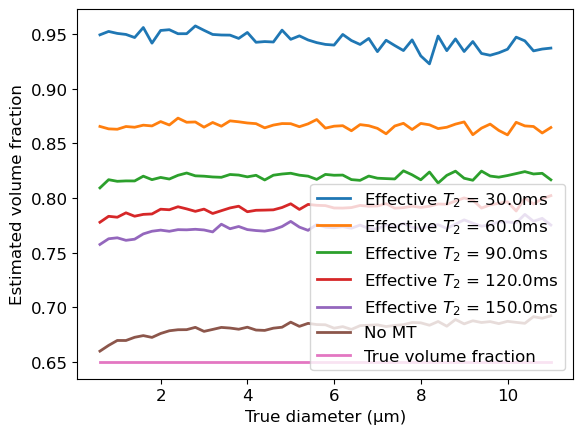

In [23]:
# List the MT values of interest
mts = range(30,151,30)

# read the fitted diameter across the whole range of underlying cylinder diameter when there's no MT or permeability (first element of the permeability results)
file_path = "precomputed_perm_params.pickle"
with open(file_path, 'rb') as file:
    params_perm = pickle.load(file)
nm_fit0 = read_fits(params_perm[0])

# For each MT effective T2 values extract the fitted diameters across the whole range of underlying cylinder diameter into a new list
for i in range(5):
    nm_fit = read_fits(params[(i+1)*3-2])
    
    # Then plot the list of fitted values
    plt.plot(np.arange(0.30, 5.51, 0.1)*2,nm_fit[:,0], label="Effective $T_2$ = " + '{0:.1f}'.format(mts[i]) + "ms" )

# Plot the no MT or permeability case and the true diameter for references
plt.plot(np.arange(0.30, 5.51, 0.1)*2, nm_fit0[:,0], label="No MT")
plt.plot([0.6,11],[0.65,0.65], label="True volume fraction")
plt.xlabel("True diameter (μm)")
plt.ylabel("Estimated volume fraction")
plt.legend(loc="lower right")
plt.show()